# Importation des bibliothèques

In [2]:
import sys
sys.path.insert(0, '..')

In [29]:
%load_ext autoreload
%autoreload 2
from modele import Module_lineare
from loss  import MSELoss
import non_lineaire as nl
import numpy as np
import matplotlib.pyplot as plt
import math
import utils as ut

from sklearn.model_selection import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Génération de données aléatoires

In [11]:
# Test de l'implémentation
# Génération de données pour la classification binaire
X = np.random.randn(1000, 2)
y = np.random.randint(2, size=1000)  # Classes binaires (0 et 1)

y = y.reshape(-1, 1)

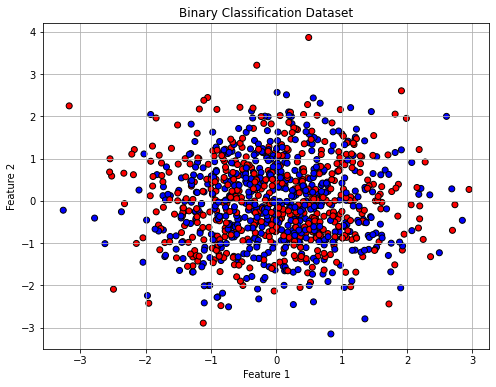

In [5]:
# Affichage des données
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', marker='o', edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Binary Classification Dataset')
plt.grid(True)
plt.show()

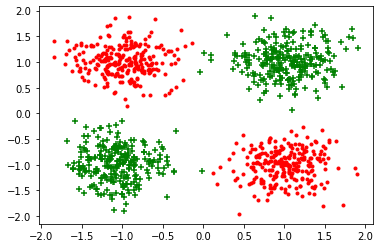

In [64]:
data, y = ut.gen_arti(centerx=1,centery=1,sigma=0.1,nbex=1000,data_type=1,epsilon=0.02)
y = np.where(y==-1,0,1).reshape((-1,1))


ut.plot_data(data,y)

Train : (800, 2)
Test : (200, 2)
Epoch 1, Loss: 0.47109290185666586
Epoch 2, Loss: 0.4710664961427841
Epoch 3, Loss: 0.4710400468436104
Epoch 4, Loss: 0.4710135538632113
Epoch 5, Loss: 0.4709870171054101
Epoch 6, Loss: 0.4709604364737854
Epoch 7, Loss: 0.47093381187167127
Epoch 8, Loss: 0.4709071432021565
Epoch 9, Loss: 0.4708804303680834
Epoch 10, Loss: 0.47085367327204836
Epoch 11, Loss: 0.4708268718163998
Epoch 12, Loss: 0.470800025903239
Epoch 13, Loss: 0.47077313543441834
Epoch 14, Loss: 0.47074620031154146
Epoch 15, Loss: 0.4707192204359623
Epoch 16, Loss: 0.4706921957087845
Epoch 17, Loss: 0.47066512603086125
Epoch 18, Loss: 0.4706380113027938
Epoch 19, Loss: 0.47061085142493164
Epoch 20, Loss: 0.4705836462973717
Epoch 21, Loss: 0.4705563958199575
Epoch 22, Loss: 0.4705290998922789
Epoch 23, Loss: 0.47050175841367115
Epoch 24, Loss: 0.47047437128321445
Epoch 25, Loss: 0.4704469383997335
Epoch 26, Loss: 0.47041945966179666
Epoch 27, Loss: 0.47039193496771525
Epoch 28, Loss: 0.470

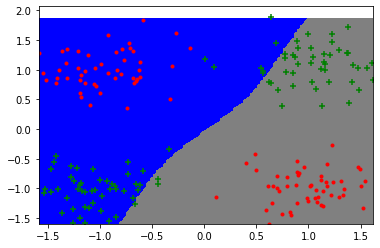

In [145]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=.2, random_state=42)
print('Train :', X_train.shape)
print('Test :', X_test.shape)


module1 = Module_lineare(input_size=2, output_size=50)
activation_tanh = nl.TanH()
module2 = Module_lineare(input_size=50, output_size=1)
activation_sigmoide = nl.Sigmoide()

loss = MSELoss()
learning_rate = 0.001

train_losses = []
test_losses = []
test_accuracies = []
best_params_module1 = None
best_params_module2 = None
loss_min = math.inf

nb_epochs = 1000

for epoch in range(nb_epochs):


    # Forward pass

    # Passe avant (forward pass)
    output1 = module1.forward(X_train)
    output1_activated = activation_tanh.forward(output1)
    output2 = module2.forward(output1_activated)
    output2_activated = activation_sigmoide.forward(output2)

    loss_train = loss.forward(y_train, output2_activated)
    train_losses.append(np.mean(loss_train))

    # Backward pass
    gradient_loss = loss.backward(y_train, output2_activated)
    
    delta_sig = activation_sigmoide.backward_delta(output2, gradient_loss)

    delta_linear_mod1 = module2.backward_delta(output1_activated, delta_sig)

    delta_tanh = activation_tanh.backward_delta(output1, delta_linear_mod1)

    delta_linear_mod1 = module1.backward_delta(X_train, delta_tanh)
    
    module2.backward_update_gradient(output1_activated, delta_sig)
    module1.backward_update_gradient(X_train, delta_tanh)


    # Mise à jour des paramètres
    module1.update_parameters(learning_rate)
    module2.update_parameters(learning_rate)

    if np.mean(loss_train) < np.mean(loss_min) :
        best_params_module1 = module1.get_parameters()
        best_params_module2 = module2.get_parameters()
        loss_min = np.mean(loss_train)
    else :
        module1.set_parameters(best_params_module1)
        module2.set_parameters(best_params_module2)


    # Test accuracy

    output1 = module1.forward(X_test)
    output1_activated = activation_tanh.forward(output1)
    output2 = module2.forward(output1_activated)
    output2_activated = activation_sigmoide.forward(output2)

    loss_test = loss.forward(y_test, output2_activated)
    test_losses.append(np.mean(loss_test))

    y_pred = np.where(output2_activated >=0.5, 1, 0)

    accuracy = len(np.where(y_test == y_pred)[0])/len(y_pred)
    # accuracy =  np.where(y_test ==y_pred)[0].mean()
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}, Loss: {np.mean(loss_train)}")
    module1.zero_grad()
    module2.zero_grad()

def predict(x):
    hidden_l = module1.forward(x)
    hidden_l = activation_tanh.forward(hidden_l)
    hidden_l = module2.forward(hidden_l)
    hidden_l = activation_sigmoide.forward(hidden_l)  
    return np.where(hidden_l >= 0.5,1, 0)

ut.plot_frontiere(X_test, predict, step=100)
ut.plot_data(X_test, y_test.reshape(-1))

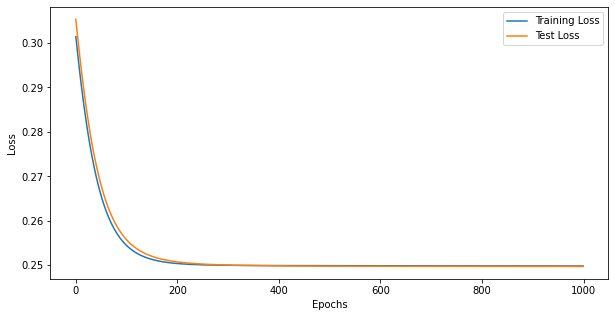

In [108]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

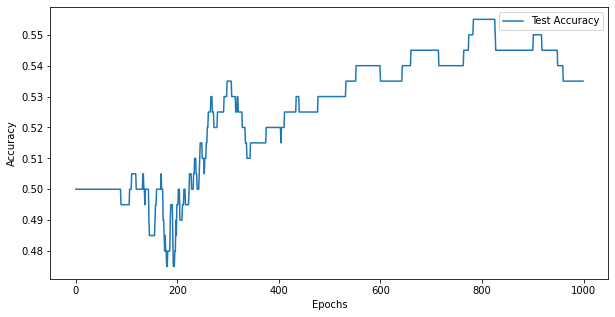

In [109]:
plt.figure(figsize=(10, 5))
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [135]:

def predict(x):
    module1 = Module_lineare(input_size=2, output_size=30)
    activation_tanh = nl.TanH()
    module2 = Module_lineare(input_size=30, output_size=1)
    activation_sigmoide = nl.Sigmoide()
    hidden_l = module1.forward(x)
    hidden_l = activation_tanh.forward(hidden_l)
    hidden_l = module2.forward(hidden_l)
    hidden_l = activation_sigmoide.forward(hidden_l)  
    return np.where(hidden_l >= 0.5,1, 0)


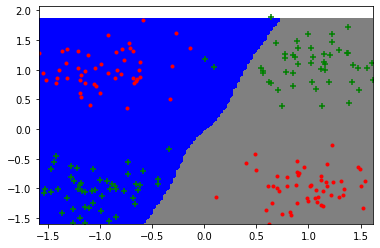

In [143]:
ut.plot_frontiere(X_test, predict, step=100)
ut.plot_data(X_test, y_test.reshape(-1))